## Basic SVOL

Our model: https://mc-stan.org/docs/stan-users-guide/stochastic-volatility-models.html

In [59]:
import pandas as pd
import numpy as np
import pyjags
from datetime import datetime
import statsmodels.stats.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

## Sampling

In [60]:
# sampling configs
ITERS=9000
CHAINS=2
BURN_IN=1000

In [61]:
''' 
  sample priors with asset return data using JAGS
  plot the distribution and chains
'''
def sample_n_plot(asset_returns, mean_log_vol, shock):
  
  # JAGS sampling
  jags_data = {"y": list(asset_returns), "N": len(asset_returns), "mlv": mean_log_vol, "s": shock}
  parameters = ['mu', 'phi', 'sigma']
  jags_model_string = '''
    model {
      mu ~ dnorm(0, 1/mlv)         # variance is inverse of the precision parameter
      phi ~ dunif(-1, 1)
      sigma ~ dnorm(0, 1/s) T(0,)

      h[1] ~ dnorm(mu, sqrt(1 - pow(phi, 2))/sigma )
      for (i in 2:N) {
        h[i] ~ dnorm(mu + phi * (h[i-1] - mu), 1/sigma)
      }
      
      for (j in 1:N) {
        y[j] ~ dnorm(0, 1/exp(h[j]/2) )
      }
    }
  '''
  jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=CHAINS, adapt=BURN_IN)
  jags_samples = jags_model.sample(iterations=ITERS, vars=parameters)

  # chains
  sample_chains = [jags_samples[p][0] for p in parameters]


  ######### checking convergence #########

  sample_chains_np = np.array(sample_chains)
  params_info = {}
  print(f'\nCHAINS: {CHAINS}, ITERS: {ITERS}, BURN-IN: {BURN_IN}')

  for p in range(len(parameters)):

    _chains = sample_chains_np[p].T
    merged_chain = _chains.flatten()
    _x = np.mean(merged_chain)
    chain_means = np.mean(_chains, axis=1)
    hdi95 = sm.DescrStatsW(merged_chain).tconfint_mean(alpha=0.05, alternative='two-sided') 

    # Gelman-Rubin Statistic
    varB = (ITERS/(CHAINS-1))*np.sum([(_x - x)**2 for x in chain_means])
    varW = sum( [ sum( [(chain_means[i] - s)**2 for s in _chains[i]] )/(ITERS - 1) for i in range(len(_chains)) ] ) / CHAINS
    varM = ((ITERS-1)*varW + varB)/ITERS
    R = np.sqrt(varM/varW)

    params_info[parameters[p]] = {'mean': _x, '95% HDI': hdi95}

    print(f'''
    Parameter: {parameters[p]}
      Mean overall: {_x}, Chain means: {chain_means}
      Between var: {varB}, Within var: {varW}
      Confidence interval (95%): {hdi95}
      Gelman-Rubin Stat: {R}'''
    )
  

  ############### plots ##################
  
  fig, axs = plt.subplots(len(parameters), 2, figsize=(10, 8))
  axs[0, 0].set_title('Samples\' distribution')
  axs[0, 1].set_title('Sampling steps')
  colors = ['brown', 'indigo']
  
  for p in range(len(parameters)):
  
    for c in range(CHAINS):
      # samples' distribution
      sns.kdeplot(data=sample_chains[p][:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.7)
      # sampling steps
      sns.lineplot(data=sample_chains[p][:, c], ax=axs[p, 1], color=colors[c], alpha=0.7)
  
    # axs[p, 0].set_facecolor('black')
    axs[p, 0].set_ylabel(parameters[p])
    # axs[p, 1].set_facecolor('black')
  
  fig.suptitle(f'MCMC sampling with pyjags with {CHAINS} chains')
  plt.tight_layout()
  plt.show()

  return params_info

## Historical data
- Historical data of stock & cryptocurrency prices from [Investing.com](https://www.investing.com/)
- Data ranging from 01-01-2015 to 31-12-2022

In [62]:
# data

df = pd.read_csv('datasets/Bitcoin.csv')
print(df.shape)
df.head()

(2922, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 31, 2022",16537.4,"16,607.2","16,635.9","16,487.3",130.44K,-0.42%
1,"Dec 30, 2022",16607.2,"16,636.4","16,644.4","16,360.0",192.76K,-0.18%
2,"Dec 29, 2022",16636.4,"16,546.2","16,659.1","16,496.6",181.47K,0.55%
3,"Dec 28, 2022",16546.2,"16,705.9","16,781.1","16,474.2",217.96K,-0.96%
4,"Dec 27, 2022",16706.1,"16,918.2","16,964.0","16,610.1",192.18K,-1.25%


In [63]:
df.describe()

,Price
count,2922.000000
mean,13301.416051
std,16289.382665
min,164.900000
25%,889.450000
50%,7369.600000
75%,17200.875000
max,67527.900000


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2922 non-null   object 
 1   Price     2922 non-null   float64
 2   Open      2922 non-null   object 
 3   High      2922 non-null   object 
 4   Low       2922 non-null   object 
 5   Vol.      2922 non-null   object 
 6   Change %  2922 non-null   object 
dtypes: float64(1), object(6)
memory usage: 159.9+ KB


In [65]:
'''
  convert string to datetime
  change formats as required for the dates
  '%m/%d/%Y'
  '%b %d, %Y'
'''

df['Date'] = df['Date'].apply(lambda dt: datetime.strptime(dt, "%b %d, %Y"))

In [66]:
# sorting data chronologically

df.sort_values(by='Date', inplace=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
2921,2015-01-01,314.9,318.2,321.4,313.5,12.82K,-1.05%
2920,2015-01-02,315.2,314.9,316.4,313.1,14.73K,0.10%
2919,2015-01-03,287.1,315.2,315.8,284.9,47.37K,-8.91%
2918,2015-01-04,264.7,287.1,289.9,255.9,88.77K,-7.80%
2917,2015-01-05,274.8,264.7,278.3,262.9,54.99K,3.82%


In [67]:
# get asset returns from closing prices
# yt = 100 * (log(Pt) - log(Pt-1))
df['Asset_return'] = np.log(df['Price'].shift(-1) / df['Price']) * 100
df['Asset_return'] = df['Asset_return'].shift(1)

df[['Asset_return']].head()

,Asset_return
2921,NaN
2920,0.095223
2919,-9.337677
2918,-8.123348
2917,3.744645


In [68]:
# have asset returns mean-corrected

ar_mean = df[['Asset_return']].mean()
df['Asset_return'] = df['Asset_return'].apply(lambda a: a - ar_mean)

In [69]:
# asset returns, removing the first NaN
asset_returns_data = df[['Asset_return']].to_numpy().flatten()[1:]

print(f'''Asset return data (mean-corrected):
  Mean: {np.mean(asset_returns_data)},
  Variance: {np.var(asset_returns_data)}'''
)

Asset return data (mean-corrected):
  Mean: 1.4595194846150638e-17,
  Variance: 15.530025030366797


<AxesSubplot: ylabel='Density'>

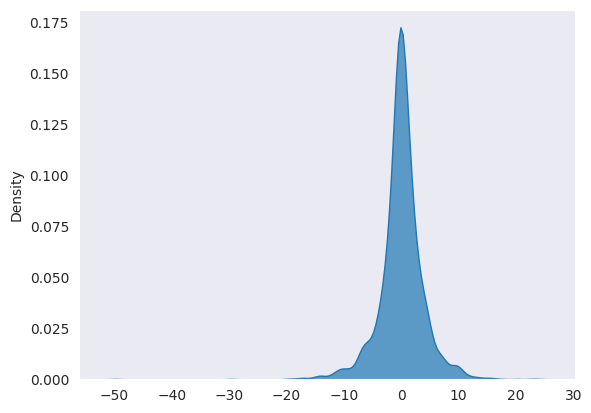

In [70]:
sns.kdeplot(data=asset_returns_data, fill=True, alpha=0.7)

In [71]:
# Initial priors

''' 
  Mean log volatility: mu
  -> take a normal distribution
  -> with mean -> 0 and variance -> variance of logarithmic returns
'''
mlv = np.mean(np.square(asset_returns_data))
print(f'Mean log volatility: {mlv}')

'''
  Persistence of volatility: phi
  -> uniform distribution between 0 to 1
  more complicated models available to estimate the persistence
'''

'''
  Shock scale distribution tends to be heavy-tailed in comparison to the swing in prices itself
  taking a wider normal distribtion
'''
shock_scale = mlv*2
print(f'Shock: {shock_scale}')


Mean log volatility: 15.530025030366797
Shock: 31.060050060733595


adapting: iterations 226 of 2000, elapsed 0:00:05, remaining 0:00:41
adapting: iterations 686 of 2000, elapsed 0:00:13, remaining 0:00:25
adapting: iterations 1222 of 2000, elapsed 0:00:22, remaining 0:00:14
adapting: iterations 1786 of 2000, elapsed 0:00:31, remaining 0:00:04
adapting: iterations 2000 of 2000, elapsed 0:00:35, remaining 0:00:00
sampling: iterations 352 of 18000, elapsed 0:00:06, remaining 0:04:39
sampling: iterations 984 of 18000, elapsed 0:00:16, remaining 0:04:29
sampling: iterations 1300 of 18000, elapsed 0:00:21, remaining 0:04:27
sampling: iterations 1612 of 18000, elapsed 0:00:26, remaining 0:04:22
sampling: iterations 1924 of 18000, elapsed 0:00:31, remaining 0:04:18
sampling: iterations 2544 of 18000, elapsed 0:00:41, remaining 0:04:08
sampling: iterations 3168 of 18000, elapsed 0:00:51, remaining 0:03:57
sampling: iterations 3480 of 18000, elapsed 0:00:56, remaining 0:03:54
sampling: iterations 4100 of 18000, elapsed 0:01:04, remaining 0:03:36
sampling: itera

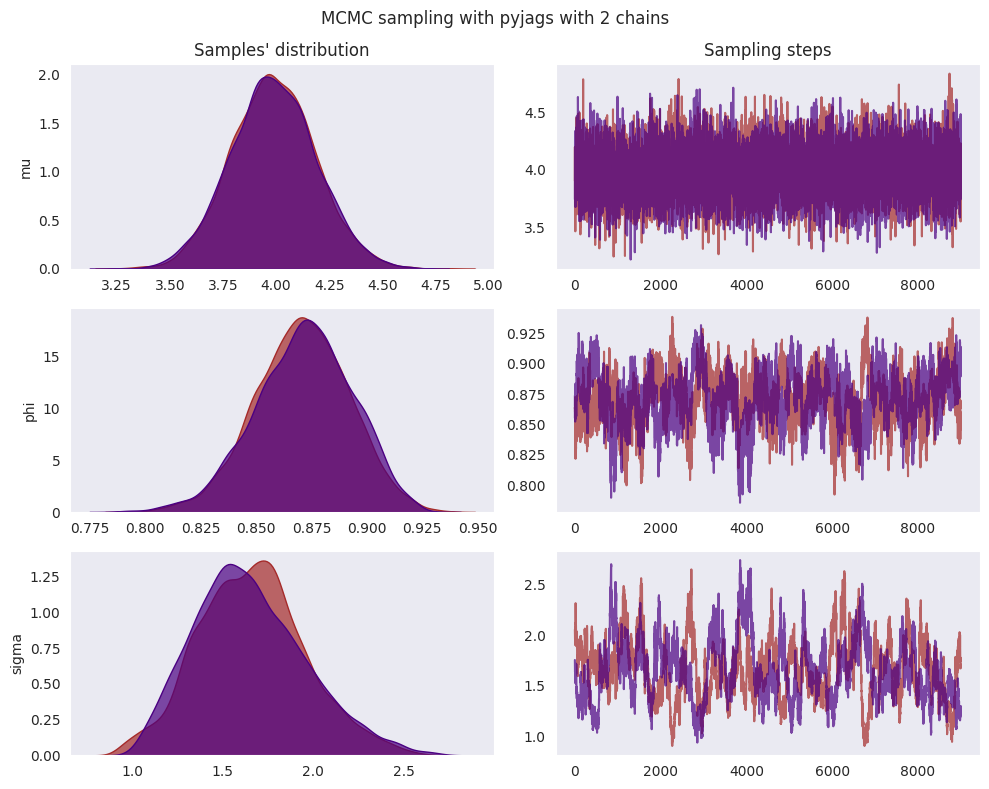

In [72]:
estimates = sample_n_plot(asset_returns=asset_returns_data, mean_log_vol=mlv, shock=shock_scale)

In [73]:
estimates

{'mu': {'mean': 3.9864680044642067,
  '95% HDI': (3.9835318710554914, 3.98940413787292)},
 'phi': {'mean': 0.8711264977652518,
  '95% HDI': (0.8708105983124231, 0.8714423972180801)},
 'sigma': {'mean': 1.655056017561398,
  '95% HDI': (1.65066698533696, 1.6594450497858355)}}

## Simulated data

In [74]:
'''
  generate asset returns as per basic SVOL model
  params:
    n: number of asset returns to generate
  returns:
    returns n simulated asset_returns
'''
def generate_data(mu, phi, sigma, n=1):
  
  hs = [] # log volatilities
  ys = [] # asset returns

  # initial values
  h0 = np.random.normal( mu, np.sqrt(sigma/np.sqrt(1 - phi**2)) )
  hs.append(h0)
  ys.append( np.random.normal( 0, np.sqrt(np.exp(h0/2)) ) )

  for i in range(1, n):
    hs.append( np.random.normal( mu + phi*(hs[i-1] - mu), np.sqrt(sigma)) )
    ys.append( np.random.normal( 0, np.sqrt(np.exp(hs[i]/2)) ) )
  return ys


In [75]:
# simulation configs from historic posterior estimate
SAMPLE_SIZE=len(asset_returns_data)
MU=estimates['mu']['mean']
PHI=estimates['phi']['mean']
SIGMA=estimates['sigma']['mean']
print(MU, PHI, SIGMA, SAMPLE_SIZE)

3.9864680044642067 0.8711264977652518 1.655056017561398 2921


In [76]:
# generate simulation data: asset returns
sim_ar = generate_data(MU, PHI, SIGMA, SAMPLE_SIZE)
print(f'''Simulated data:
  Mean: {np.mean(sim_ar)},
  Variance: {np.var(sim_ar)}'''
)

Simulated data:
  Mean: -0.019276032413292867,
  Variance: 19.86644124414846


In [77]:
# Mean-correction
sim_x = np.mean(sim_ar)
corrected_sim_ar = [ar - sim_x for ar in sim_ar]
print(f'''Simulated data (mean-ceorrected):
  Mean: {np.mean(corrected_sim_ar)},
  Variance: {np.var(corrected_sim_ar)}'''
)

Simulated data (mean-ceorrected):
  Mean: 2.9190389692301276e-17,
  Variance: 19.86644124414846


<AxesSubplot: ylabel='Density'>

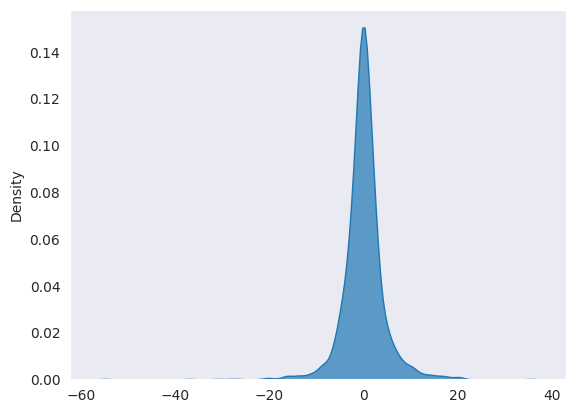

In [78]:
sns.kdeplot(data=corrected_sim_ar, fill=True, alpha=0.7)

In [79]:
# Initial priors

''' 
  Mean log volatility: mu
  -> take a normal distribution
  -> with mean -> 0 and variance -> variance of logarithmic returns
'''

sim_mlv = np.mean(np.square(corrected_sim_ar))
print(f'Mean log volatility: {sim_mlv}')

'''
  Persistence of volatility: phi
  -> uniform distribution between 0 to 1
  more complicated models available to estimate the persistence
'''

'''
  Shock scale distribution tends to be heavy-tailed in comparison to the swing in prices itself
  taking a wider normal distribtion
'''
sim_shock_scale = sim_mlv*2
print(f'Shock: {sim_shock_scale}')

Mean log volatility: 19.86644124414846
Shock: 39.73288248829692


adapting: iterations 810 of 2000, elapsed 0:00:09, remaining 0:00:13
adapting: iterations 1758 of 2000, elapsed 0:00:18, remaining 0:00:03
adapting: iterations 2000 of 2000, elapsed 0:00:21, remaining 0:00:00
sampling: iterations 942 of 18000, elapsed 0:00:10, remaining 0:02:54
sampling: iterations 1924 of 18000, elapsed 0:00:20, remaining 0:02:44
sampling: iterations 2904 of 18000, elapsed 0:00:30, remaining 0:02:34
sampling: iterations 3394 of 18000, elapsed 0:00:35, remaining 0:02:29
sampling: iterations 4374 of 18000, elapsed 0:00:44, remaining 0:02:19
sampling: iterations 5354 of 18000, elapsed 0:00:54, remaining 0:02:08
sampling: iterations 5846 of 18000, elapsed 0:00:59, remaining 0:02:04
sampling: iterations 6830 of 18000, elapsed 0:01:09, remaining 0:01:54
sampling: iterations 7320 of 18000, elapsed 0:01:15, remaining 0:01:49
sampling: iterations 7808 of 18000, elapsed 0:01:21, remaining 0:01:46
sampling: iterations 8288 of 18000, elapsed 0:01:27, remaining 0:01:42
sampling: i

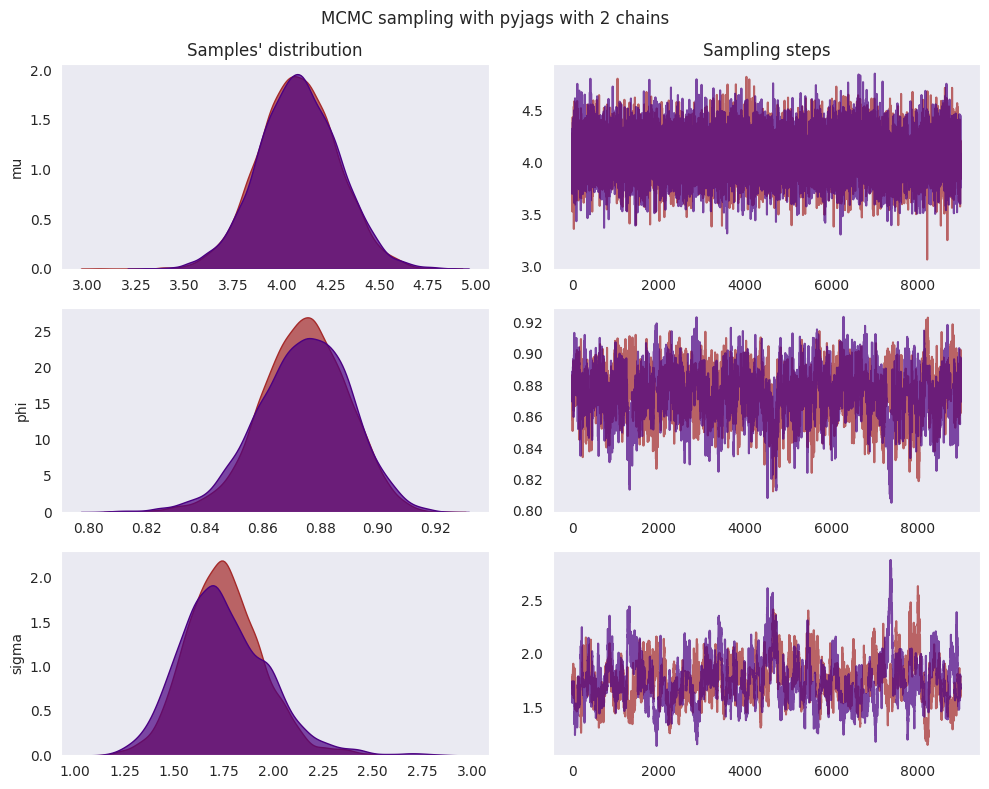

{'mu': {'mean': 4.082742311389909,
  '95% HDI': (4.079755514634818, 4.0857291081449985)},
 'phi': {'mean': 0.8743411465147661,
  '95% HDI': (0.8741144970764438, 0.8745677959530886)},
 'sigma': {'mean': 1.7509849616243642,
  '95% HDI': (1.7478834251918003, 1.7540864980569282)}}

In [80]:
sample_n_plot(asset_returns=corrected_sim_ar, mean_log_vol=sim_mlv, shock=sim_shock_scale)